In [2]:
f1C11='so_subsets/1C-CS-81E41S160E64S.GPM.GMI.XCAL2016-C.20240901-S054432-E055430.059683.V07B.HDF5'
f2ADPR='so_subsets/2A-CS-81E41S160E64S.GPM.DPR.V9-20240130.20240901-S054546-E055514.059683.V07C.HDF5'
f2BCMB='so_subsets/2B-CS-81E41S160E64S.GPM.DPRGMI.CORRA2022.20240901-S054546-E055514.059683.V07C.HDF5'
import glob
fnames=sorted(glob.glob('so_subsets/*.059684*.HDF5'))
print(fnames)
f1C11=fnames[0]
f2ADPR=fnames[1]
fgprof=fnames[2]
f2BCMB=fnames[3]
import io_subs
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyresample import image, geometry
qv_dpr,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw_dpr,sfcBin,zCorrected,pType,lon,lat,oe_wvp,oe_lwp,oe_iwp,oesfc_precip,stormTop,nearSfcPrecip,zeroDegAltitude,surfaceType=io_subs.readCMB(f2BCMB)
pType=(pType/1e7).astype(int)
lat_s1,lon_s1,tb_s1=io_subs.read1CGMI(f1C11)

input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling
wf = lambda r: 1 - r/20000.0
tb_s1_resampled = resample_custom(input_def, tb_s1[:,:,:], output_def, radius_of_influence=50000, neighbours=10, 
weight_funcs=[wf for k in range(9)], fill_value=None)

hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
a=[2,4,6,8]
import pickle


['so_subsets/1C-CS-81E41S160E64S.GPM.GMI.XCAL2016-C.20240901-S071747-E073028.059684.V07B.HDF5', 'so_subsets/2A-CS-81E41S160E64S.GPM.DPR.V9-20240130.20240901-S071900-E073029.059684.V07C.HDF5', 'so_subsets/2A-CS-81E41S160E64S.GPM.GMI.GPROF2021v1.20240901-S071747-E073028.059684.V07C.HDF5', 'so_subsets/2B-CS-81E41S160E64S.GPM.DPRGMI.CORRA2022.20240901-S071900-E073029.059684.V07C.HDF5']


/Users/mgrecu/miniforge3/lib/python3.12/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 50000 m for some data points
  get_neighbour_info(source_geo_def,


In [3]:
import pickle
with open('../precipDiagnostics/pca_profs.pkl','rb') as f:
    d_pca=pickle.load(f)
    pca=d_pca['pca']
    x_all_vars_mean=d_pca['x_all_vars_mean']
    x_all_vars_std=d_pca['x_all_vars_std']

#d_knn_tb={'knn':knn,'tb_mean':tb_mean,'tb_std':tb_std}
#with open('knn_tb.pkl','wb') as f:
#    pickle.dump(d_knn_tb,f)

with open('../precipDiagnostics/knn_tb.pkl','rb') as f:
    d_knn_tb=pickle.load(f)
    knn_tb=d_knn_tb['knn']
    tb_mean=d_knn_tb['tb_mean']
    tb_std=d_knn_tb['tb_std']


/Users/mgrecu/miniforge3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mgrecu/miniforge3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
print('tb_s1_resampled.shape',tb_s1_resampled.shape)
x_input=(tb_s1_resampled.reshape(-1,9)-tb_mean[:9])/tb_std[:9]
y_output=knn_tb.predict(x_input)
emiss_pred=y_output[:,:11].reshape(-1,49,11)
cldw_pred=y_output[:,11:12].reshape(-1,49)
pca_pred=y_output[:,12:]
y_geo_pred=pca.inverse_transform(pca_pred)*x_all_vars_std+x_all_vars_mean

tb_s1_resampled.shape (985, 49, 9)


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
# Custom transformer for normalization
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

# Custom transformer for reshaping
class Reshaper(BaseEstimator, TransformerMixin):
    def __init__(self, shape):
        self.shape = shape

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(self.shape)

# Custom transformer for inverse PCA transformation
class InversePCA(BaseEstimator, TransformerMixin):
    def __init__(self, pca, std, mean):
        self.pca = pca
        self.std = std
        self.mean = mean

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.pca.inverse_transform(X) * self.std + self.mean

# Assuming you have the following variables defined:
# tb_s1_resampled, tb_mean, tb_std, knn_tb, pca, x_all_vars_std, x_all_vars_mean

# Create the pipeline


KNeighborsRegressor()

In [16]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.common.shape_calculator import calculate_linear_regressor_output_shapes
from skl2onnx.common.data_types import guess_numpy_type
from skl2onnx.common._apply_operation import apply_add, apply_div
from skl2onnx import update_registered_converter
from skl2onnx import to_onnx
import onnx
def normalizer_shape_calculator(operator):
    input = operator.inputs[0]
    operator.outputs[0].type = input.type.__class__([input.type.shape[0], input.type.shape[1]])

def normalizer_converter(scope, operator, container):
    input = operator.inputs[0]
    output = operator.outputs[0]
    mean = operator.raw_operator.mean.astype(np.float32)
    std = operator.raw_operator.std.astype(np.float32)
    
    mean_name = scope.get_unique_variable_name('mean')
    std_name = scope.get_unique_variable_name('std')
    
    container.add_initializer(mean_name, onnx.TensorProto.FLOAT, mean.shape, mean)
    container.add_initializer(std_name, onnx.TensorProto.FLOAT, std.shape, std)
    
    sub_result = scope.get_unique_variable_name('sub_result')
    apply_add(scope, [input.full_name, mean_name], [sub_result], container, operator_name=None, axis=1)
    apply_div(scope, [sub_result, std_name], [output.full_name], container, operator_name=None, axis=1)

# Register the custom converter
update_registered_converter(Normalizer, 'Normalizer', normalizer_shape_calculator, normalizer_converter)

pipeline = Pipeline([
    ('normalizer', Normalizer(mean=tb_mean[:9], std=tb_std[:9])),
    ('knn', KNeighborsRegressor(5)),  # Assuming knn_tb is a KNeighborsRegressor
])

pipeline.named_steps['knn'].fit((tb_s1_resampled.reshape(-1, 9) - tb_mean[:9]) / tb_std[:9], knn_tb.predict((tb_s1_resampled.reshape(-1, 9) - tb_mean[:9]) / tb_std[:9]))

initial_type = [('float_input', FloatTensorType([None, 9]))]
onnx_model = convert_sklearn(pipeline, initial_types=initial_type)

onnx_model_path = "pipeline_model.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [4]:
print(y_geo_pred.shape)
#x_all_vars=np.concatenate([pressure_at_surface[:,np.newaxis],temperature_2m[:,np.newaxis],qv,temperature,geopotential],axis=1)
pressure_at_surface=y_geo_pred[:,0].reshape(-1,49)
temperature_2m=y_geo_pred[:,1].reshape(-1,49)
qv=y_geo_pred[:,2:39].reshape(-1,49,37)
temperature=y_geo_pred[:,39:76].reshape(-1,49,37)
geopotential=y_geo_pred[:,76:].reshape(-1,49,37)

(48265, 113)


In [25]:
import numpy as np
ndpr=qv_dpr.shape[0]
tb_sim=np.zeros((ndpr,49,11),float)
import sdsu_tables as sdsu
freq_gmi=[10.65,10.65,18.7,18.7,23.8,36.5,36.5,89.0,89.0,166,166]

incAngle=53.0
u_10m=0.0
v_10m=0.0
press=np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000])
for i in range(ndpr):
    for j in range(49):
        ts=temperature_2m[i,j]
        cldw=cldw_pred[i,j]
        emiss=emiss_pred[i,j,:]
        ebar=emiss
        tb_all_freq2=sdsu.calculate_tb_prof_1d(incAngle,freq_gmi,temperature_2m,u_10m,v_10m,1.1*qv[i,j,:],geopotential[i,j,:],temperature[i,j,:],press, cldw, emiss)
        tb_sim[i,j,:]=tb_all_freq2

In [ ]:
# gcc  onnx_example.c -I onnxruntime-osx-arm64-1.19.0/include/ -L onnxruntime-osx-arm64-1.19.0/lib/ -lonnxruntime


0.6477349236293454
0.9798898317099173
0.9336472305756999
0.9967990953141346
0.9865180727543446
0.9447794849646803
0.9929615531342422
0.9684109626858657


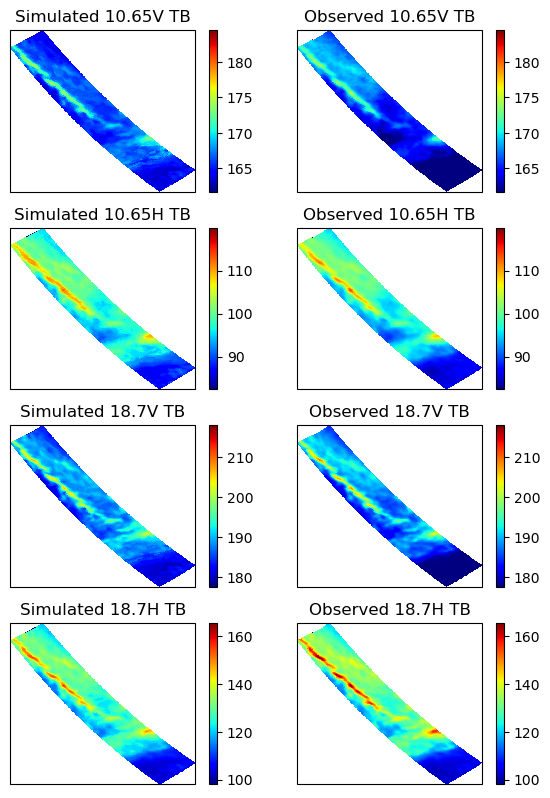

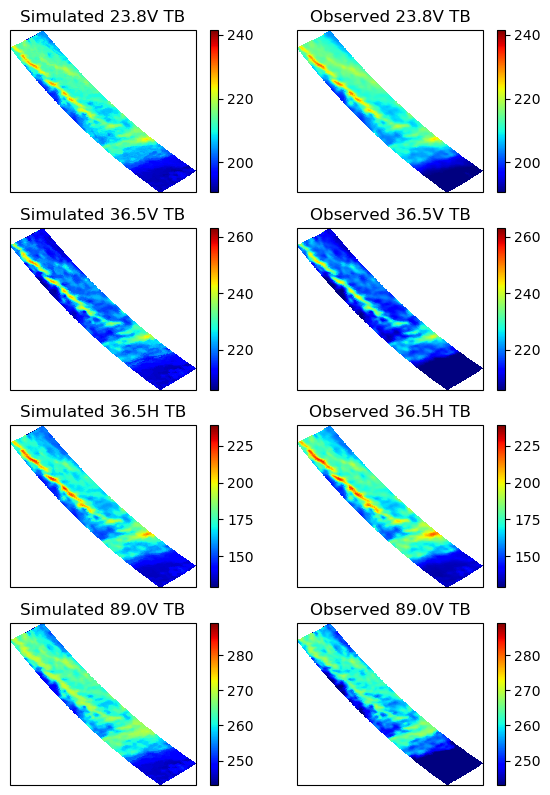

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.figure(figsize=(6,12))
channels=['10.65V','10.65H','18.7V','18.7H','23.8V','36.5V','36.5H','89.0V','89.0H','166V','166H']
for i in range(4):
    #ax=plt.subplot(3,3,i+1,projection=ccrs.PlateCarree())
    ax=plt.subplot(6,2,2*i+1,projection=ccrs.PlateCarree())

    #plt.scatter(tb_sim[:ndpr//3,:,i].flatten(),tb_s1_resampled[:ndpr//3,:,i].flatten())
    #a=np.nonzero(tb_s1_resampled[:ndpr//3,:,i]>50)
    print(np.corrcoef(tb_sim[:ndpr//3,:,i][a],tb_s1_resampled[:ndpr//3,:,i][a])[0,1])
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],tb_sim[:ndpr//3,:,i],cmap='jet',vmin=tb_sim[:ndpr//3,:,i].min(),vmax=1.05*tb_sim[:ndpr//3,:,i].max())
    plt.title('Simulated %s TB'%channels[i])
    plt.colorbar()
    ax=plt.subplot(6,2,2*i+2,projection=ccrs.PlateCarree())
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],tb_s1_resampled[:ndpr//3,:,i],cmap='jet',vmin=tb_sim[:ndpr//3,:,i].min(),vmax=1.05*tb_sim[:ndpr//3,:,i].max())
    plt.title('Observed %s TB'%channels[i])
    plt.colorbar()

plt.tight_layout()
plt.savefig('simulated_tb_channels_1_4.png')

plt.figure(figsize=(6,12))
channels=['10.65V','10.65H','18.7V','18.7H','23.8V','36.5V','36.5H','89.0V','89.0H','166V','166H']
for i in range(4,8):
    #ax=plt.subplot(3,3,i+1,projection=ccrs.PlateCarree())
    ax=plt.subplot(6,2,2*(i-4)+1,projection=ccrs.PlateCarree())

    #plt.scatter(tb_sim[:ndpr//3,:,i].flatten(),tb_s1_resampled[:ndpr//3,:,i].flatten())
    #a=np.nonzero(tb_s1_resampled[:ndpr//3,:,i]>50)
    print(np.corrcoef(tb_sim[:ndpr//3,:,i][a],tb_s1_resampled[:ndpr//3,:,i][a])[0,1])
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],tb_sim[:ndpr//3,:,i],cmap='jet',vmin=tb_sim[:ndpr//3,:,i].min(),vmax=1.05*tb_sim[:ndpr//3,:,i].max())
    plt.title('Simulated %s TB'%channels[i])
    plt.colorbar()
    ax=plt.subplot(6,2,2*(i-4)+2,projection=ccrs.PlateCarree())
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],tb_s1_resampled[:ndpr//3,:,i],cmap='jet',vmin=tb_sim[:ndpr//3,:,i].min(),vmax=1.05*tb_sim[:ndpr//3,:,i].max())
    plt.title('Observed %s TB'%channels[i])
    plt.colorbar()

plt.tight_layout()
plt.savefig('simulated_tb_channels_5_8.png')

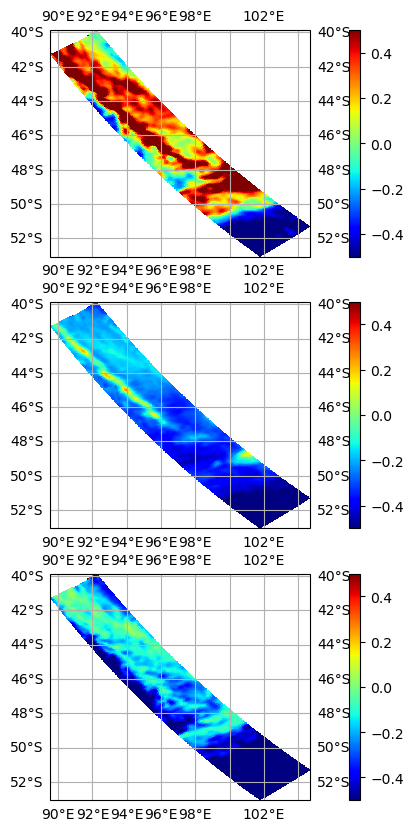

In [20]:

features=[]
for i in range(3):
    features.append(tb_ecoded[:,i].reshape(ndpr//3,49))
plt.figure(figsize=(10,10))
isign=[-1,1,-1]
for i in range(3):
    ax=plt.subplot(3,1,i+1,projection=ccrs.PlateCarree())
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],isign[i]*features[i],cmap='jet',vmin=-0.5,vmax=0.5)
    gl2=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    plt.colorbar()

In [4]:

#pickle.dump(knn,open('knncldwp_4.pklz','wb'))
#pickle.dump(knn_tpw,open('knntpw_4.pklz','wb'))
#knn=pickle.load(open('knncldwp_4.pklz','rb'))
#knn_tpw=pickle.load(open('knntpw_4.pklz','rb'))
ndpr=qv.shape[0]
#d_model={"tb_mean":tb_mean[:9],"tb_std":tb_std[:9],"total_column_water_vapor_mean":total_column_water_vapor.mean(),"total_column_water_vapor_std":total_column_water_vapor.std(),"cldwp_mean":cldwp.mean(),"cldwp_std":cldwp.std(),"model":knn}
import pickle
#with open('knn_gmi_s1_model.pkl', 'wb') as f:
#    pickle.dump(d_model, f)
d_model=pickle.load(open('knn_gmi_s1_model.pkl','rb'))
tb_mean=d_model["tb_mean"]
tb_std=d_model["tb_std"]
total_column_water_vapor_mean=d_model["total_column_water_vapor_mean"]
total_column_water_vapor_std=d_model["total_column_water_vapor_std"]
cldwp_mean=d_model["cldwp_mean"]
cldwp_std=d_model["cldwp_std"]
knn=d_model["model"]

x_input=tb_s1_resampled[:ndpr//3,:,:].reshape(-1,9)
x_input=(x_input-tb_mean)/tb_std
y_out=knn.predict(x_input)
total_column_water_vapor_predicted=y_out[:,0]*total_column_water_vapor_std+total_column_water_vapor_mean
cldwp_predicted=y_out[:,1]*cldwp_std+cldwp_mean


In [11]:
print(tb_mean)

[169.75692749023438 93.41938781738281 194.39111328125 128.16268920898438
 221.89120483398438 221.03565979003906 163.11097717285156
 267.5454406738281 240.66546630859375]


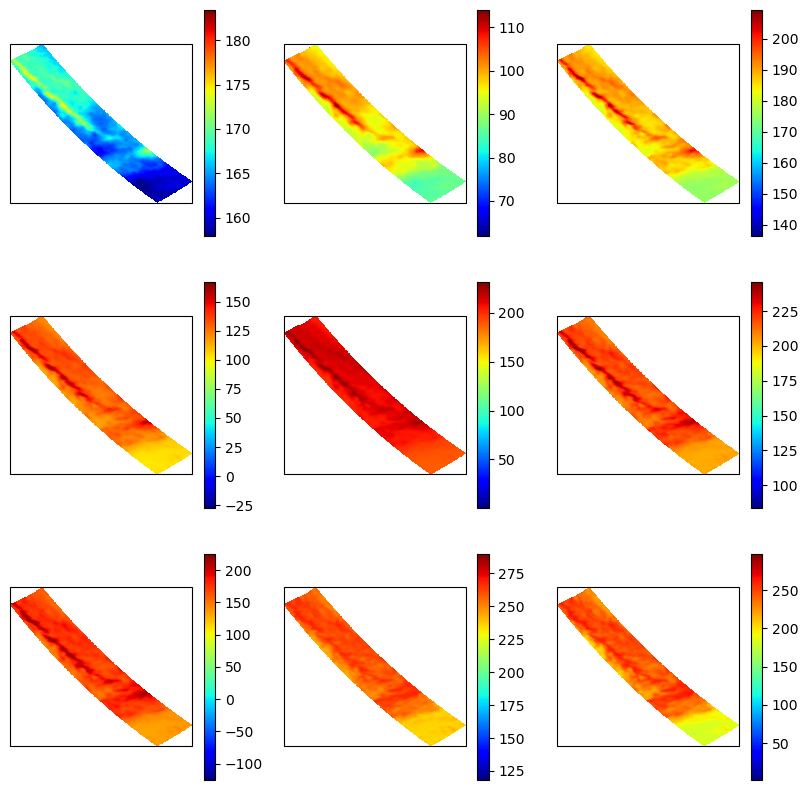

In [10]:
plt.figure(figsize=(10,10))

for i in range(9):
    ax=plt.subplot(3,3,i+1,projection=ccrs.PlateCarree())
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],tb_s1_resampled[:ndpr//3,:,i],cmap='jet')
    plt.colorbar()

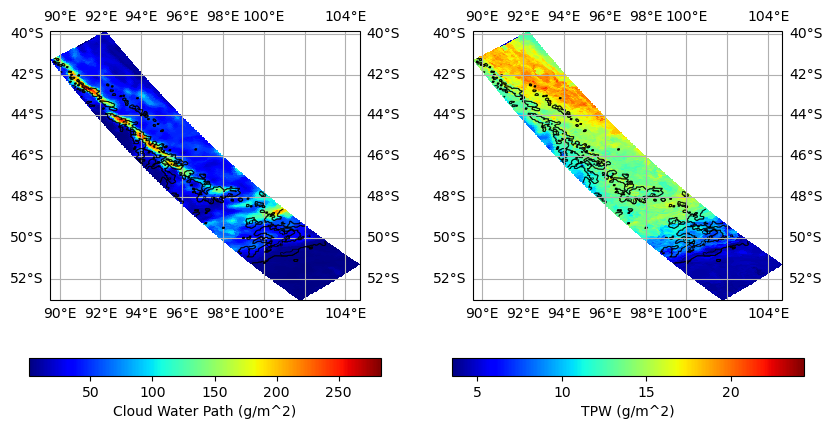

In [6]:
tpw_2d=total_column_water_vapor_predicted.reshape(ndpr//3,49)
cldwp_2d=cldwp_predicted.reshape(ndpr//3,49)
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

ax=plt.subplot(121,projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.right_labels=False
ax.top_labels=False
c=plt.pcolormesh(lon[:ndpr//3],lat[:ndpr//3],cldwp_2d*250,cmap='jet',transform=ccrs.PlateCarree())
plt.contour(lon[:ndpr//3],lat[:ndpr//3],pType[:ndpr//3,:],levels=[0.1,0.5,1],colors='black',transform=ccrs.PlateCarree(),linewidths=0.5)
plt.colorbar(c,orientation='horizontal',label='Cloud Water Path (g/m^2)')
#plt.figure()
ax2=plt.subplot(122,projection=ccrs.PlateCarree())
c2=plt.pcolormesh(lon[:ndpr//3],lat[:ndpr//3],tpw_2d,cmap='jet',transform=ccrs.PlateCarree())
plt.contour(lon[:ndpr//3],lat[:ndpr//3],pType[:ndpr//3,:],levels=[0.1,0.5,1],colors='black',transform=ccrs.PlateCarree(),linewidths=0.5)
gl2=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl2.xlabels_top = False
gl2.ylabels_right = False
#gl2.ylabel_artist.set_fontsize(8)
#ax2.draw_meridians(np.arange(-180,180,5),labels=[0,0,0,1])
#gl2.xlabels_top = False
plt.colorbar(c2,orientation='horizontal',label='TPW (g/m^2)')
plt.savefig('retrieved_cldwp_tpw_2_59684.png',dpi=300)
